## **Import Library**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

## **Load Data**

Data makanan dibaca dari file food.csv dan disimpan dalam DataFrame food_df.
Data penilaian pengguna dibaca dari file ratings.csv dan disimpan dalam rating_df.

In [2]:
food_df = pd.read_csv("food.csv")
food_df.head()

,Food_ID,Name,C_Type,Veg_Non,Describe
0,1,summer squash salad,Healthy Food,veg,"white balsamic vinegar, lemon juice, lemon rin..."
1,2,chicken minced salad,Healthy Food,non-veg,"olive oil, chicken mince, garlic (minced), oni..."
2,3,sweet chilli almonds,Snack,veg,"almonds whole, egg white, curry leaves, salt, ..."
3,4,tricolour salad,Healthy Food,veg,"vinegar, honey/sugar, soy sauce, salt, garlic ..."
4,5,christmas cake,Dessert,veg,"christmas dry fruits (pre-soaked), orange zest..."


In [3]:
rating_df = pd.read_csv("ratings.csv")
rating_df.head()

,User_ID,Food_ID,Rating
0,1.0,88.0,4.0
1,1.0,46.0,3.0
2,1.0,24.0,5.0
3,1.0,25.0,4.0
4,2.0,49.0,1.0


## **Data Understanding**

Mengecek Informasi data

In [4]:
food_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Food_ID   400 non-null    int64 
 1   Name      400 non-null    object
 2   C_Type    400 non-null    object
 3   Veg_Non   400 non-null    object
 4   Describe  400 non-null    object
dtypes: int64(1), object(4)
memory usage: 15.8+ KB


Dataset berisi 400 entri makanan dengan 5 kolom, yaitu ID, nama, kategori, jenis (veg/non-veg), dan deskripsi. Semua kolom lengkap tanpa nilai kosong.

In [5]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   User_ID  511 non-null    float64
 1   Food_ID  511 non-null    float64
 2   Rating   511 non-null    float64
dtypes: float64(3)
memory usage: 12.1 KB


Data rating pengguna terdiri dari 512 entri dengan 3 kolom: User_ID, Food_ID, dan Rating.
Terdapat 1 baris yang memiliki nilai kosong pada ketiga kolom tersebut.

**Exploratory Data Analysis**

Mengecek missing value pada data food

In [6]:
food_df.isna().sum()

,0
Food_ID,0
Name,0
C_Type,0
Veg_Non,0
Describe,0


Tidak terdapat missing value pada data food

Mengecek missing value pada data rating

In [7]:
rating_df.isna().sum()

,0
User_ID,1
Food_ID,1
Rating,1


Terdapat 1 baris missing value pada ketiga kolom tersebut.

Mengecek Duplikat

In [8]:
food_df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
395,False
396,False
397,False
398,False


In [9]:
rating_df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
507,False
508,False
509,False
510,False


Tidak terdapat data duplikat dikedua dataset

Melihat informasi statistik data rating

In [10]:
rating_df.describe()

,User_ID,Food_ID,Rating
count,511.000000,511.000000,511.000000
mean,49.068493,125.311155,5.438356
std,28.739213,91.292629,2.866236
min,1.000000,1.000000,1.000000
25%,25.000000,45.500000,3.000000
50%,49.000000,111.000000,5.000000
75%,72.000000,204.000000,8.000000
max,100.000000,309.000000,10.000000


User_ID berkisar 1–100 dengan rata-rata 49, dan Food_ID antara 1–309 dengan rata-rata 125. Rating memiliki rata-rata 5.4, median 5, dengan rentang nilai 1–10, menunjukkan distribusi penilaian yang merata.

In [11]:
print('Jumlah makanan unik:', food_df['Name'].nunique())
print('tipe makanan: ', food_df['C_Type'].unique())
print('tipe vegetarian: ', food_df['Veg_Non'].unique())

Jumlah makanan unik: 400
tipe makanan:  ['Healthy Food' 'Snack' 'Dessert' 'Japanese' 'Indian' 'French' 'Mexican'
 'Italian' 'Chinese' 'Beverage' 'Thai' 'Korean' ' Korean' 'Vietnames'
 'Nepalese' 'Spanish']
tipe vegetarian:  ['veg' 'non-veg']


Ditemukan duplikasi kategori "Korean" karena perbedaan spasi ('Korean' dan ' Korean'), dan hal ini akan dibersihkan agar konsisten.

In [12]:
print('Jumlah Rating:', rating_df['Rating'].nunique())
print('Tipe Rating: ', rating_df['Rating'].unique())

Jumlah Rating: 10
Tipe Rating:  [ 4.  3.  5.  1.  8.  9. 10.  6.  2.  7. nan]


Terdapat 10 jenis rating unik dari 1 hingga 10, dan satu nilai NaN pada kolom Rating yang akan dihapus untuk memastikan data bersih.


Distribusi tipe/kategori makanan

<ipython-input-13-af66c5194b70>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=food_df, x='C_Type', palette='viridis')


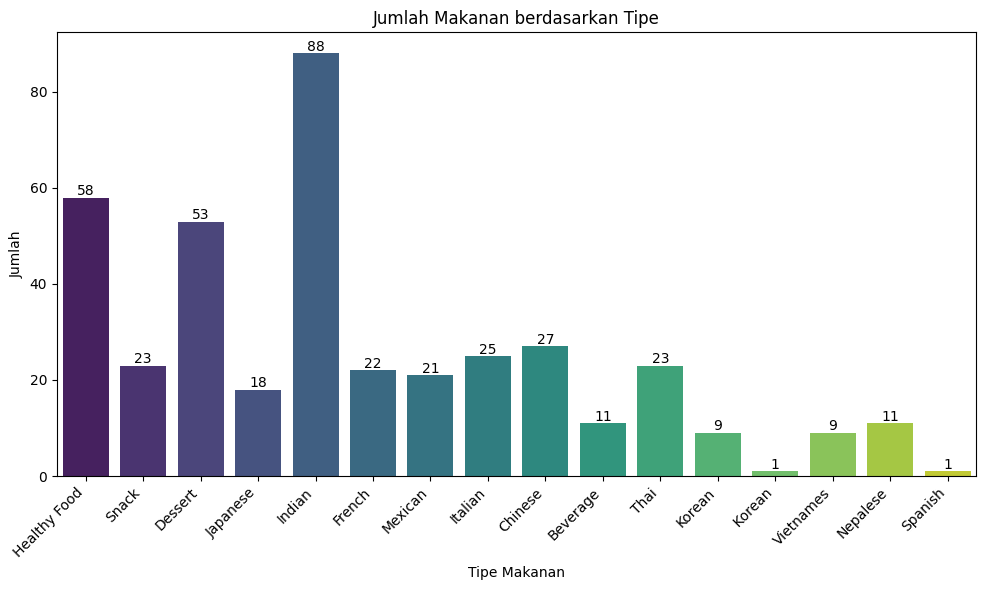

In [13]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=food_df, x='C_Type', palette='viridis')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height()+0.5, int(p.get_height()), ha='center')
plt.title('Jumlah Makanan berdasarkan Tipe')
plt.xlabel('Tipe Makanan')
plt.ylabel('Jumlah')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Grafik menunjukkan kategori makanan terbanyak adalah Indian (88), diikuti Healthy Food (58) dan Dessert (53).
Beberapa kategori seperti Korean dan Spanish hanya memiliki 1 makanan, dengan duplikasi label Korean yang perlu dibersihkan.

Distribusi tipe vegetarian

<ipython-input-14-da53af0d6033>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=food_df, x='Veg_Non', palette='viridis')


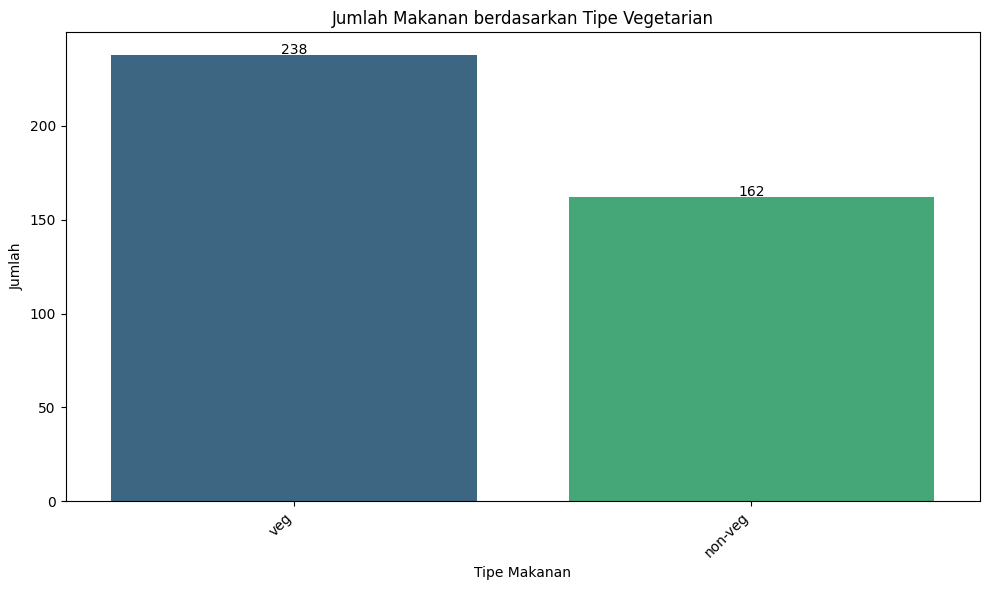

In [14]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=food_df, x='Veg_Non', palette='viridis')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height()+0.5, int(p.get_height()), ha='center')
plt.title('Jumlah Makanan berdasarkan Tipe Vegetarian')
plt.xlabel('Tipe Makanan')
plt.ylabel('Jumlah')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Grafik menunjukkan jumlah makanan berdasarkan tipe vegetarian, dengan 238 makanan veg dan 162 non-veg. Ini menunjukkan bahwa makanan vegetarian lebih dominan.

Distribusi rating

<ipython-input-15-1d60f096f7b6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=rating_df, x='Rating', palette='viridis')


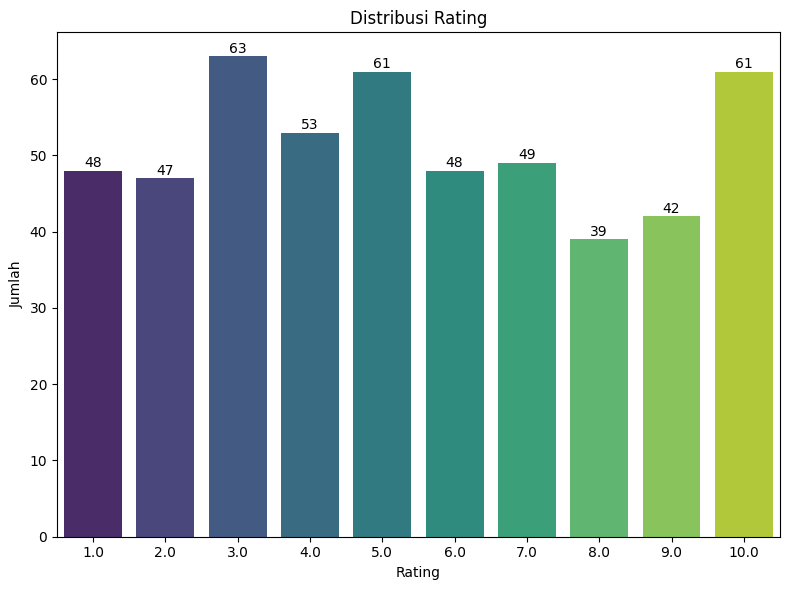

In [15]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=rating_df, x='Rating', palette='viridis')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height()+0.5, int(p.get_height()), ha='center')
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

Grafik menunjukkan rating 3, 5, dan 10 paling sering muncul, sementara rating 8 paling sedikit. Distribusi rating bervariasi dan tidak simetris.


<ipython-input-16-c86ed3ca06e1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=rating_df['Rating'], palette='viridis')


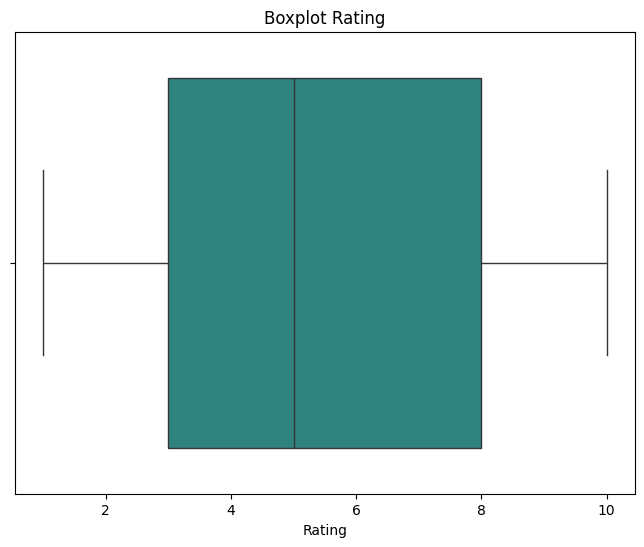

In [16]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=rating_df['Rating'], palette='viridis')
plt.title('Boxplot Rating')
plt.xlabel('Rating')
plt.show()

Berdasarkan grafik boxplot, tidak terdapat outlier, yang menunjukkan bahwa seluruh nilai rating berada dalam rentang yang wajar.

# **Content Based Filtering**

## **Data Preparation**

menggabungkan kategori yang sama tapi terpisah karna spasi

In [17]:
food_df['C_Type'] = food_df['C_Type'].str.strip()
print('Tipe makanan setelah dibersihkan:', food_df['C_Type'].unique())

Tipe makanan setelah dibersihkan: ['Healthy Food' 'Snack' 'Dessert' 'Japanese' 'Indian' 'French' 'Mexican'
 'Italian' 'Chinese' 'Beverage' 'Thai' 'Korean' 'Vietnames' 'Nepalese'
 'Spanish']


Kategori makanan yang sama namun terpisah karena spasi, seperti 'Korean' dan ' Korean', telah digabungkan.
Setelah dibersihkan, tipe makanan menjadi konsisten, terdiri dari 15 kategori unik.

menghapus kolom 'Describe' karena tidak dibutuhkan

In [18]:
data = food_df.drop(columns=['Describe'])

Kolom 'C_Type' dan 'Veg_Non' digabung menjadi satu kolom baru 'combined', yang berisi informasi gabungan jenis makanan dan apakah makanan tersebut vegetarian atau non-vegetarian. Ini akan digunakan sebagai dasar untuk menghitung kesamaan antar item.

In [19]:
data['combined'] = data['C_Type'] + ' ' + data['Veg_Non']

In [20]:
data.head()

,Food_ID,Name,C_Type,Veg_Non,combined
0,1,summer squash salad,Healthy Food,veg,Healthy Food veg
1,2,chicken minced salad,Healthy Food,non-veg,Healthy Food non-veg
2,3,sweet chilli almonds,Snack,veg,Snack veg
3,4,tricolour salad,Healthy Food,veg,Healthy Food veg
4,5,christmas cake,Dessert,veg,Dessert veg


TF-IDF Vectorization : mengubah teks di kolom 'combined' menjadi matriks TF-IDF menggunakan TfidfVectorizer. Matriks tersebut merepresentasikan seberapa penting tiap kata dalam setiap dokumen untuk analisis atau model machine learning.

In [21]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(data['combined'])

Ekstraksi Fitur dan Cosine Similarity : mengekstrak daftar kata dari TF-IDF dan menghitung kemiripan antar dokumen menggunakan cosine similarity. Hasilnya berupa matriks yang menunjukkan seberapa mirip setiap dokumen satu sama lain berdasarkan isi teksnya.

In [22]:
feature_names = vectorizer.get_feature_names_out()
print("Ukuran matriks TF-IDF:", tfidf_matrix.shape)

cosine_sim = cosine_similarity(tfidf_matrix)
print("Ukuran matriks similaritas kosinus:", cosine_sim.shape)

Ukuran matriks TF-IDF: (400, 18)
Ukuran matriks similaritas kosinus: (400, 400)


In [23]:
# Konversi ke DataFrame
cm_df = pd.DataFrame(cosine_sim, index=data['Name'], columns=data['Name'])

In [24]:
cm_df

Name,summer squash salad,chicken minced salad,sweet chilli almonds,tricolour salad,christmas cake,japanese curry arancini with barley salsa,chocolate nero cookies,lamb and chargrilled bell pepper soup,cream of almond soup,broccoli and almond soup,...,Grilled Clams With Herb Butter,Rajas Poblanas,Braised Beef Short Ribs,Fig and Sesame Tart with Cardamom Orange Cream,Rouille,Kimchi Toast,"Tacos de Gobernador (Shrimp, Poblano, and Cheese Tacos)",Melted Broccoli Pasta With Capers and Anchovies,Lemon-Ginger Cake with Pistachios,Rosemary Roasted Vegetables
Name,,,,,,,,,,,,,,,,,,,,,
summer squash salad,1.000000,0.912690,0.059732,1.000000,0.074402,0.056490,0.074402,0.912690,1.000000,1.000000,...,0.053362,0.058484,0.046448,0.063799,0.059115,0.050096,0.052896,0.053362,0.063799,1.000000
chicken minced salad,0.912690,1.000000,0.054517,0.912690,0.067906,0.051558,0.067906,1.000000,0.912690,0.912690,...,0.224558,0.053377,0.195466,0.268480,0.053954,0.045722,0.222597,0.224558,0.268480,0.912690
sweet chilli almonds,0.059732,0.054517,1.000000,0.059732,0.080044,0.060775,0.080044,0.054517,0.059732,0.059732,...,0.057409,0.062919,0.049971,0.068637,0.063599,0.053895,0.056907,0.057409,0.068637,0.059732
tricolour salad,1.000000,0.912690,0.059732,1.000000,0.074402,0.056490,0.074402,0.912690,1.000000,1.000000,...,0.053362,0.058484,0.046448,0.063799,0.059115,0.050096,0.052896,0.053362,0.063799,1.000000
christmas cake,0.074402,0.067906,0.080044,0.074402,1.000000,0.075700,1.000000,0.067906,0.074402,0.074402,...,0.071507,0.078371,0.062243,0.857492,0.079217,0.067131,0.070883,0.071507,0.857492,0.074402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kimchi Toast,0.050096,0.045722,0.053895,0.050096,0.067131,0.050970,0.067131,0.045722,0.050096,0.050096,...,0.048147,0.052768,0.927195,0.057564,0.053338,1.000000,0.047727,0.048147,0.057564,0.050096
"Tacos de Gobernador (Shrimp, Poblano, and Cheese Tacos)",0.052896,0.222597,0.056907,0.052896,0.070883,0.053819,0.070883,0.222597,0.052896,0.052896,...,0.234404,0.904454,0.204036,0.280252,0.056319,0.047727,1.000000,0.234404,0.280252,0.052896
Melted Broccoli Pasta With Capers and Anchovies,0.053362,0.224558,0.057409,0.053362,0.071507,0.054293,0.071507,0.224558,0.053362,0.053362,...,1.000000,0.056209,0.205834,0.282720,0.902672,0.048147,0.234404,1.000000,0.282720,0.053362


## **Model Development** dan **Recomendation**

Membuat fungsi rekomendasi berdasarkan kemiripan teks menggunakan matriks cosine similarity. Fungsi get_recommendation_df menerima nama item dan jumlah rekomendasi (top_k), lalu:

1. Mengambil data awal item yang dicari (df_awal).

2. Mengambil skor kemiripan tertinggi dari matriks kemiripan, kecuali item itu sendiri.

3. Mengambil data dari item yang paling mirip beserta skor kemiripannya.

4. Mengembalikan data awal dan daftar rekomendasi.

In [25]:
def get_recommendation_df(item_name, top_k=5):
    df_awal = data[data['Name'] == item_name][['Name', 'C_Type', 'Veg_Non']].copy().reset_index(drop=True)

    sim_scores = cm_df[item_name].drop(index=item_name)
    top_similar = sim_scores.sort_values(ascending=False).head(top_k)

    df_rekomendasi = data.set_index('Name').loc[top_similar.index][['C_Type', 'Veg_Non']].copy()
    df_rekomendasi['Similarity'] = top_similar.values
    df_rekomendasi = df_rekomendasi.reset_index()

    return df_awal, df_rekomendasi

Contoh pemanggilan fungsi dengan item "Rosemary Roasted Vegetables" akan menampilkan data awal dan 5 rekomendasi teratas yang paling mirip.

In [26]:
df_awal, df_rekomendasi = get_recommendation_df("Rosemary Roasted Vegetables", top_k=5)

# Tampilkan hasil
print("Data Awal:")
display(df_awal)

print("\nRekomendasi:")
display(df_rekomendasi)

Data Awal:


,Name,C_Type,Veg_Non
0,Rosemary Roasted Vegetables,Healthy Food,veg



Rekomendasi:


,Name,C_Type,Veg_Non,Similarity
0,Quinoa Tabbouleh,Healthy Food,veg,1.0
1,summer squash salad,Healthy Food,veg,1.0
2,Shirazi Salad,Healthy Food,veg,1.0
3,spicy watermelon soup,Healthy Food,veg,1.0
4,carrot ginger soup,Healthy Food,veg,1.0


## **Evaluasi**

Menggunakan Presicion
mengukur proporsi rekomendasi yang tepat dari keseluruhan item yang disarankan kepada pengguna. Precision pada top-N menunjukkan berapa banyak dari N rekomendasi teratas yang benar-benar relevan atau sesuai dengan preferensi pengguna.

$$
\text{Precision} = \frac{\text{Jumlah item rekomendasi yang relevan}}{\text{Total jumlah item yang direkomendasikan}}
$$

Semua 5 rekomendasi memenuhi kriteria tersebut → artinya semuanya relevan.

$$
\text{Precision@5} = \frac{5 \text{ item relevan}}{5 \text{ item yang direkomendasikan}} = 1.0 \text{ atau } 100\%
$$

# **Collaborative Filtering**

## **Data Preparation**

Menghapus missing value pada data rating

In [27]:
rating_df = rating_df.dropna()

In [28]:
rating_df.isna().sum()

,0
User_ID,0
Food_ID,0
Rating,0


In [29]:
rating_df.head()

,User_ID,Food_ID,Rating
0,1.0,88.0,4.0
1,1.0,46.0,3.0
2,1.0,24.0,5.0
3,1.0,25.0,4.0
4,2.0,49.0,1.0


mengubah kolom User_ID dan Food_ID bertipe int, agar bisa diproses lebih lanjut secara numerik, terutama untuk encoding dan pemodelan.

In [30]:
rating_df['User_ID'] = rating_df['User_ID'].astype(int)
rating_df['Food_ID'] = rating_df['Food_ID'].astype(int)

<ipython-input-30-9a3af4e92d06>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df['User_ID'] = rating_df['User_ID'].astype(int)
<ipython-input-30-9a3af4e92d06>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df['Food_ID'] = rating_df['Food_ID'].astype(int)


Encoding ID User dan Food : mengubah ID pengguna dan makanan dari bentuk asli ke angka berurutan agar cocok untuk model machine learning. Kamus dibuat untuk konversi dua arah antara ID asli dan angka, lalu data rating_df di-update dengan ID yang sudah diencoding. Proses ini memudahkan pemrosesan dan pelatihan model.

In [31]:
user_ids = rating_df['User_ID'].unique().tolist()
food_ids = rating_df['Food_ID'].unique().tolist()

user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

food_to_food_encoded = {x: i for i, x in enumerate(food_ids)}
food_encoded_to_food = {i: x for i, x in enumerate(food_ids)}

In [32]:
# Terapkan encoding ke DataFrame
rating_df['User_ID'] = rating_df['User_ID'].map(user_to_user_encoded)
rating_df['Food_ID'] = rating_df['Food_ID'].map(food_to_food_encoded)

<ipython-input-32-c66372385fcb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df['User_ID'] = rating_df['User_ID'].map(user_to_user_encoded)
<ipython-input-32-c66372385fcb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df['Food_ID'] = rating_df['Food_ID'].map(food_to_food_encoded)


Normalisasi rating ke 0-1 membuat data lebih konsisten, membantu model machine learning lebih stabil dalam proses training.

In [33]:
rating_df['Rating'] = rating_df['Rating'] / 10.0

<ipython-input-33-d909940a5308>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df['Rating'] = rating_df['Rating'] / 10.0


In [34]:
print("List User_ID:", user_ids)
print("Encoded User_ID:", user_to_user_encoded)
print("Decoded User_ID dari angka:", user_encoded_to_user)

print("List Food_ID:", food_ids)
print("Encoded Food_ID:", food_to_food_encoded)
print("Decoded Food_ID dari angka:", food_encoded_to_food)

List User_ID: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
Encoded User_ID: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 47: 46, 48: 47, 49: 48, 50: 49, 51: 50, 52: 51, 53: 52, 54: 53, 55: 54, 56: 55, 57: 56, 58: 57, 59: 58, 60: 59, 61: 60, 62: 61, 63: 62, 64: 63, 65: 64, 66: 65, 67: 66, 68: 67, 69: 68, 70: 69, 71: 70, 72: 71, 73: 72, 74: 73, 75

In [35]:
rating_df.head()

,User_ID,Food_ID,Rating
0,0,0,0.4
1,0,1,0.3
2,0,2,0.5
3,0,3,0.4
4,1,4,0.1


Pengacakan Data (Shuffle)

In [36]:
rating_df = rating_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [37]:
rating_df.head()

,User_ID,Food_ID,Rating
0,23,67,0.5
1,15,78,0.3
2,82,282,0.1
3,48,191,1.0
4,12,64,0.8


Split data dengan rasio 80:20 membagi data menjadi 80% untuk pelatihan dan 20% untuk pengujian, lalu menyiapkan input dan output agar model dapat dilatih dan diuji.

In [38]:
train_df, val_df = train_test_split(rating_df, test_size=0.2, random_state=42)

print(f'Jumlah data training: {len(train_df)}')
print(f'Jumlah data validation: {len(val_df)}')

Jumlah data training: 408
Jumlah data validation: 103


In [39]:
x_train = np.array(list(zip(train_df['User_ID'], train_df['Food_ID'])))
y_train = train_df['Rating']

x_val = np.array(list(zip(val_df['User_ID'], val_df['Food_ID'])))
y_val = val_df['Rating']

## **Model Development** dan **Recomendation**

 model rekomendasi berbasis embedding menggunakan TensorFlow. Model membuat representasi vektor (embedding) untuk pengguna dan makanan, lalu menghitung interaksi mereka dengan dot product ditambah bias. Hasilnya diproses lewat fungsi sigmoid untuk memprediksi rating dalam rentang 0-1.

In [40]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_food, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = layers.Embedding(
            num_users, embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)

        self.food_embedding = layers.Embedding(
            num_food, embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.food_bias = layers.Embedding(num_food, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        food_vector = self.food_embedding(inputs[:, 1])
        food_bias = self.food_bias(inputs[:, 1])

        # Gunakan reduce_sum untuk dot product
        dot_user_food = tf.reduce_sum(user_vector * food_vector, axis=1, keepdims=True)

        # Tambahkan bias
        x = dot_user_food + user_bias + food_bias

        # Output sigmoid, dan squeeze agar bentuknya (batch,)
        return tf.nn.sigmoid(tf.squeeze(x, axis=1))

In [41]:
num_users = len(user_to_user_encoded)
print("Jumlah user:", num_users)

num_food = len(food_to_food_encoded)
print("Jumlah makanan (food):", num_food)

Jumlah user: 100
Jumlah makanan (food): 309


membuat dan mengompilasi model dengan embedding 50, menggunakan loss Binary Crossentropy, optimizer Adam, dan metrik Mean Absolute Error.

In [42]:
model = RecommenderNet(num_users, num_food, 50)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

In [43]:
_ = model(tf.constant([[0, 0]]))

model.summary()

Model: "recommender_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (1, 50)                │         5,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (1, 1)                 │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (1, 50)                │        15,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (1, 1)                 │           309 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,859 (81.48 KB)

 Trainable params: 20,859 (81.48 KB)

 Non-trainable params: 0 (0.00 B)

Callback EarlyStopping menghentikan pelatihan saat model tidak membaik untuk mencegah overfitting.

In [44]:
early_stopping = EarlyStopping(
    monitor='val_mean_absolute_error',
    patience=5,
    restore_best_weights=True
)

Training Model

In [45]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=8,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6914 - mean_absolute_error: 0.2509 - val_loss: 0.6895 - val_mean_absolute_error: 0.2434
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6817 - mean_absolute_error: 0.2339 - val_loss: 0.6890 - val_mean_absolute_error: 0.2428
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6707 - mean_absolute_error: 0.2220 - val_loss: 0.6886 - val_mean_absolute_error: 0.2424
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6596 - mean_absolute_error: 0.2041 - val_loss: 0.6883 - val_mean_absolute_error: 0.2418
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6491 - mean_absolute_error: 0.1936 - val_loss: 0.6879 - val_mean_absolute_error: 0.2414
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6368 - mean_absolute_error: 0.1766 - val_loss: 0.6877 - val_mean_absolute_error: 0.2410
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6225 - mean_absolute_error: 0.1765 - val_loss

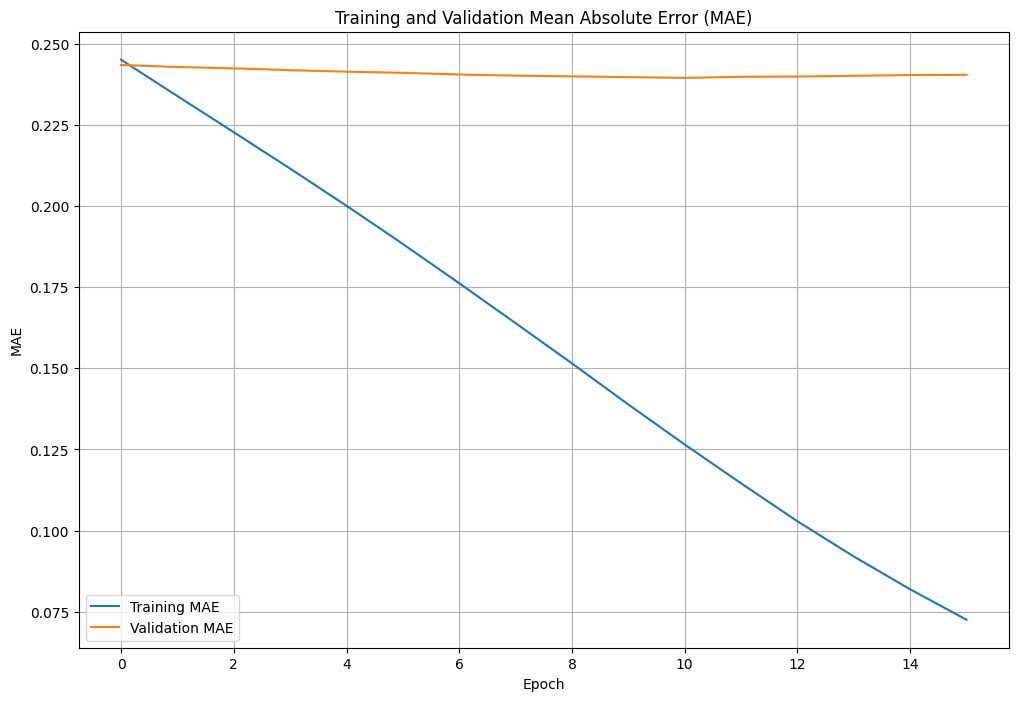

In [46]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

**recommend_for_user** yang merekomendasikan makanan baru kepada user berdasarkan prediksi model terhadap makanan yang belum pernah dirating user tersebut, dan **show_user_rated_food** yang menampilkan daftar makanan beserta rating yang sudah diberikan user. Fungsi rekomendasi memilih makanan dengan skor prediksi tertinggi, sedangkan fungsi rating menampilkan data asli hasil rating user. Contoh penggunaan menunjukkan kedua hasil ini untuk user dengan ID 2, membantu memahami preferensi dan rekomendasi yang diberikan.

In [53]:
def recommend_for_user(user, top_k=5):
    if user not in user_to_user_encoded:
        return "User ID tidak ditemukan."
    u_enc = user_to_user_encoded[user]
    rated = rating_df[rating_df['User_ID'] == u_enc]['Food_ID'].tolist()
    not_rated = [food_encoded_to_food[i] for i in food_encoded_to_food if i not in rated]

    preds = model.predict(np.array([[u_enc, food_to_food_encoded[f]] for f in not_rated])).flatten()
    top_idx = np.argsort(preds)[::-1][:top_k]

    res = food_df[food_df['Food_ID'].isin([food_encoded_to_food[food_to_food_encoded[not_rated[i]]] for i in top_idx])].copy()
    res['Predicted_Rating'] = preds[top_idx] * 10
    return res[['Name', 'C_Type', 'Veg_Non', 'Predicted_Rating']]


def show_user_rated_food(user):
    if user not in user_to_user_encoded:
        return "User ID tidak ditemukan."
    u_enc = user_to_user_encoded[user]
    rated = rating_df[rating_df['User_ID'] == u_enc].copy()
    rated['Food_ID_Orig'] = rated['Food_ID'].map(food_encoded_to_food)
    merged = rated.merge(food_df, left_on='Food_ID_Orig', right_on='Food_ID')
    merged['Rating'] *= 10
    return merged[['Name', 'C_Type', 'Veg_Non', 'Rating']]


# Contoh penggunaan
user = 2
print("Makanan sudah dirating:")
display(show_user_rated_food(user))
print("Rekomendasi makanan:")
display(recommend_for_user(user))


Makanan sudah dirating:


,Name,C_Type,Veg_Non,Rating
0,moong dal kiwi coconut soup,Indian,veg,8.0
1,carrot ginger soup,Healthy Food,veg,8.0
2,chicken nimbu dhaniya shorba,Beverage,non-veg,9.0
3,christmas tree pizza,Italian,veg,1.0


Rekomendasi makanan:
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Name,C_Type,Veg_Non,Predicted_Rating
43,andhra pan fried pomfret,Indian,veg,6.194409
183,vegetable bruschetta,Italian,veg,6.157183
202,banana and chia tea cake,Dessert,veg,6.036716
257,lamb korma,Indian,non-veg,6.017826
294,tandoori chicken,Indian,non-veg,5.991272


## **Evaluasi**

**Mean Absolute Error (MAE)** digunakan untuk mengukur seberapa besar rata-rata kesalahan antara nilai rating aktual dengan rating yang diprediksi oleh model. Semakin kecil nilai MAE, semakin baik kinerja model.

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} | y_i - \hat{y}_i |
$$


Selama 16 epoch pelatihan, MAE pada data training menurun drastis dari 0.2509 menjadi 0.0699, menunjukkan model belajar dengan baik. Namun, pada data validasi, penurunan MAE hanya terjadi di awal (dari 0.2434 ke 0.2395 hingga epoch 11), lalu stagnan hingga 0.2404 di epoch 16, menandakan overfitting, di mana model kurang mampu memprediksi data baru secara akurat.